# The SynNet architecture

This tutorial describes a simple feed-forward architecture designed for spiking networks, for temporal signal processing applications.
This architecture has been validated and published in [1, 2].

[1] Bos & Muir 2022. "Sub-mW Neuromorphic SNN audio processing applications with Rockpool and Xylo." ESSCIRC2022. https://arxiv.org/abs/2208.12991

[2] Bos & Muir 2024. "Micro-power spoken keyword spotting on Xylo Audio 2." arXiv. https://arxiv.org/abs/2406.15112

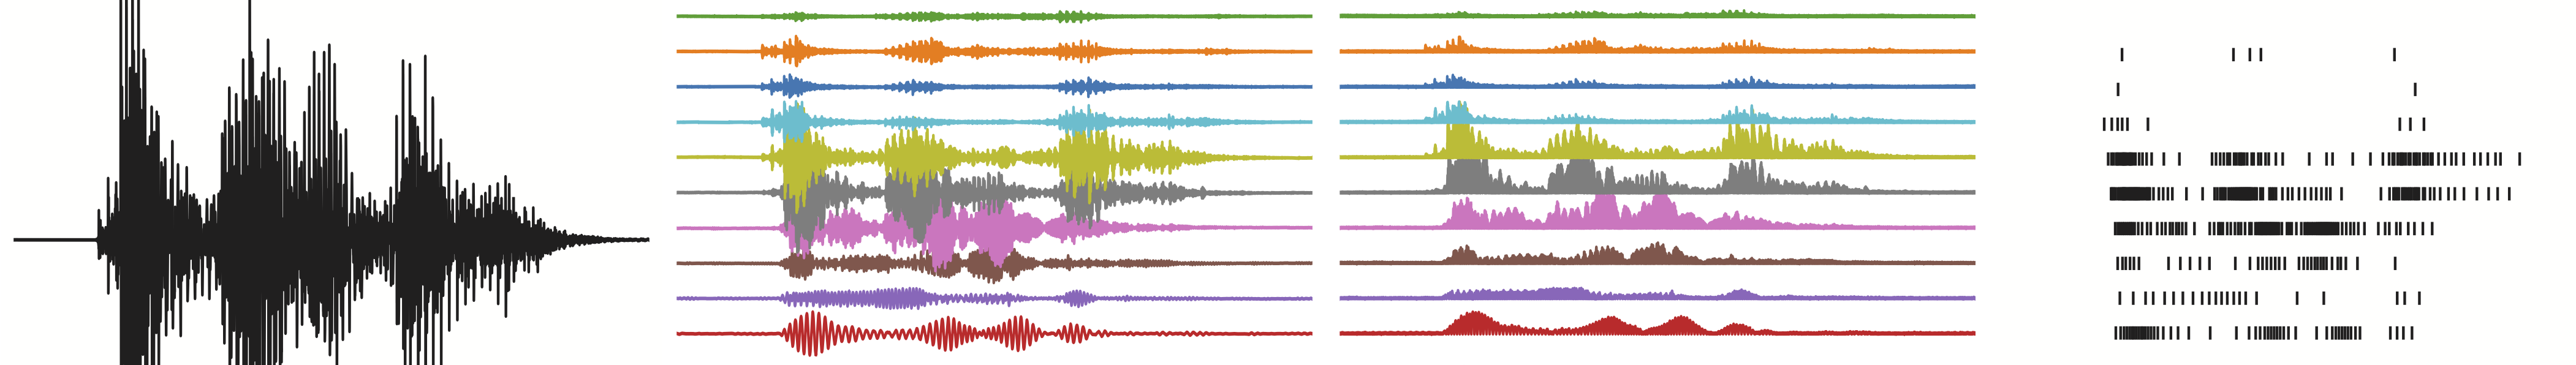

In [1]:
from IPython.display import Image

try:
    from rich import print
except:
    pass

Image("illustration_signals.png")

## Architecture description

The network consists of several hidden spiking layers, connected in a dense feed-forward chain with interleaved linear weights.
The synaptic time constants of the hidden layers are initialised with a range of values from a minimum time constant up to many multiples of the minimum time constant, in a geometric series.
This allows the network to extract and use temporal features over a range of temporal durations.

The network is specified by providing the number of input and output channels, and lists of the layer sizes and numbers of time constants in each layer.

A simple example is shown below, with 16 input channels; three hidden layers of 24 neurons each; and 1 output channel.
Default membrane and base synaptic time constants of 2ms are used, along with a default time-step `dt` of 1ms.

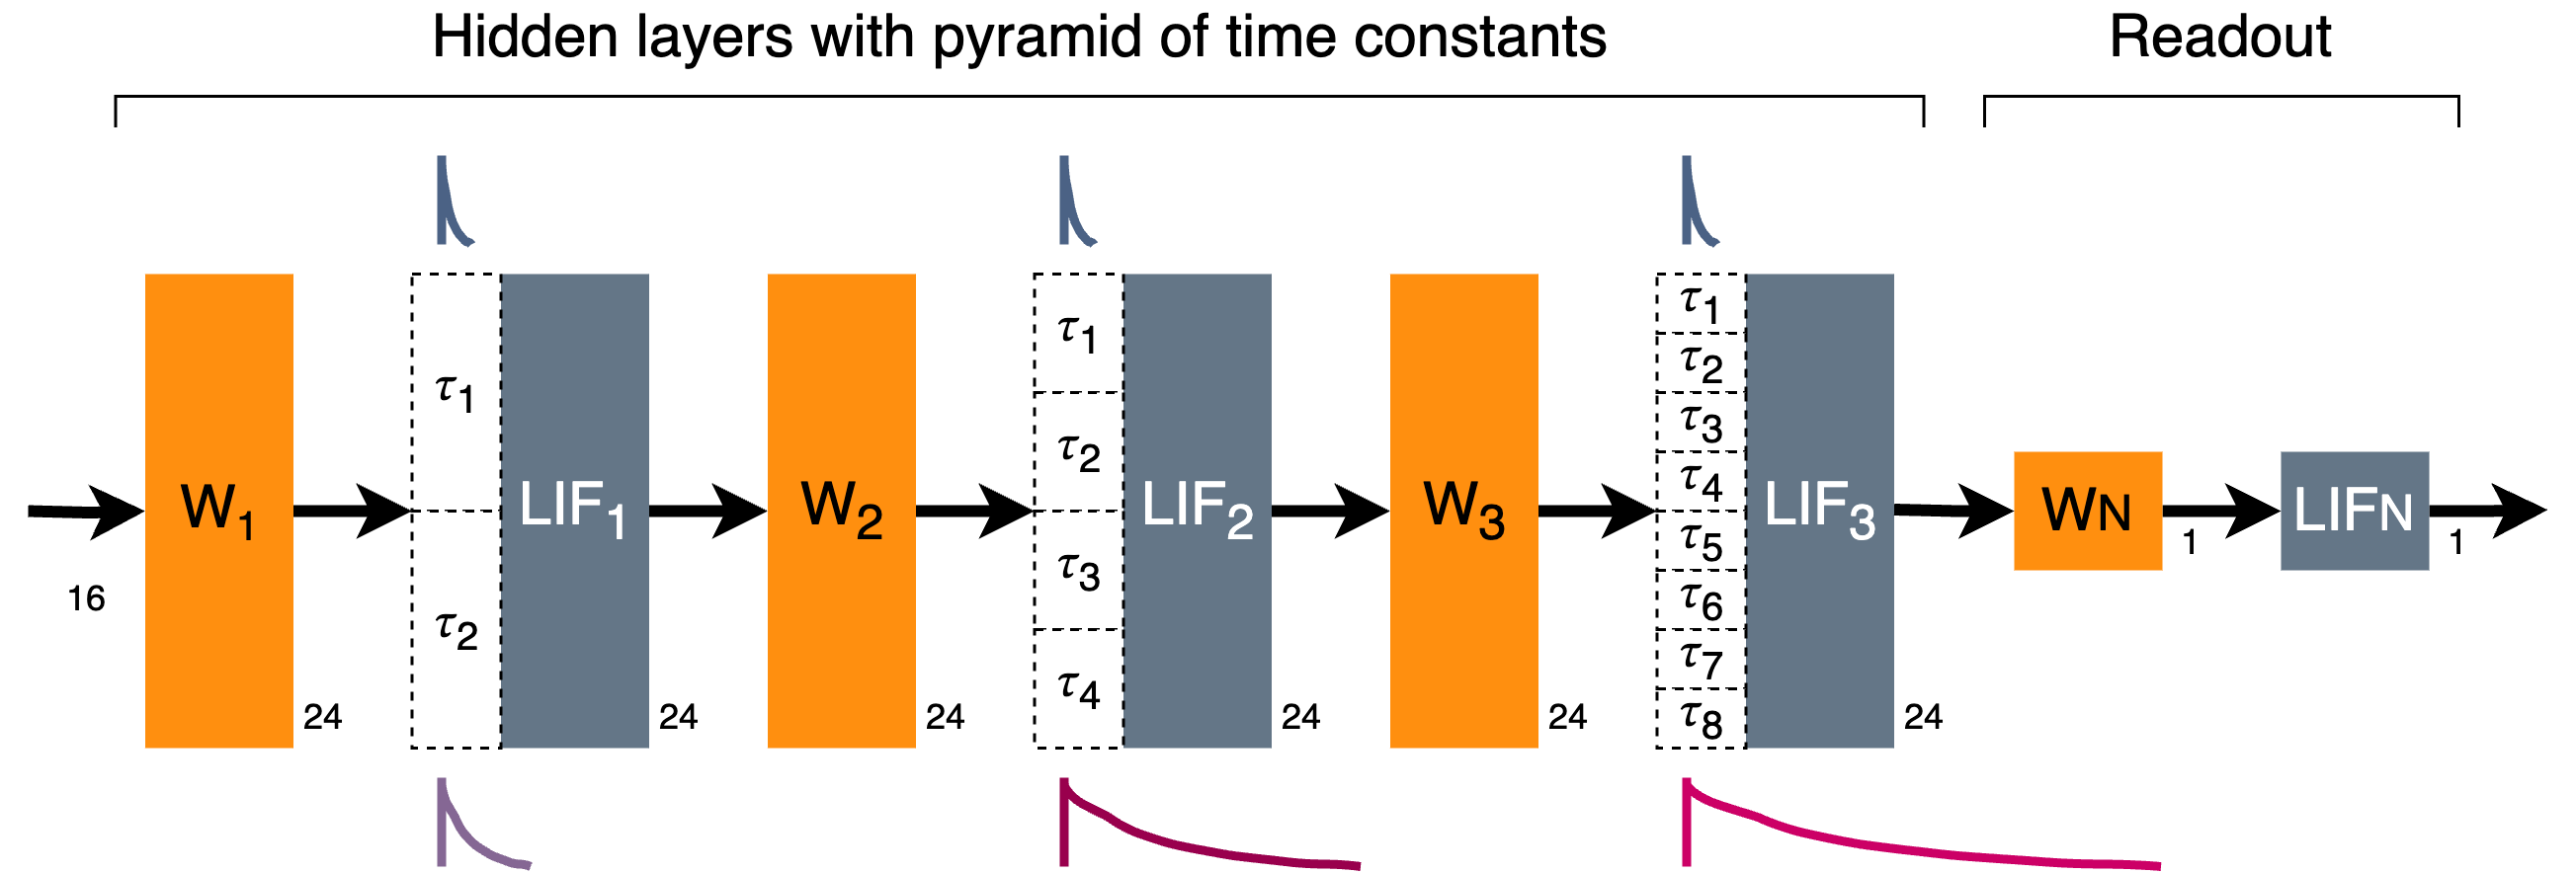

In [2]:
# - Display the network architecture to be used
Image("synnet-3-layer.png")

In [3]:
# - Import the SynNet architecture class
from rockpool.nn.networks import SynNet

# - Build a simple SynNet with three hidden layers
net = SynNet(
    n_channels = 16,                        # Number of input channels
    n_classes = 1,                          # Number of output classes (i.e. output channels)
    size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
)
print(net)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_linear' with shape (16, 24)
        LIFTorch '0_neurons' with shape (24, 24)
        LinearTorch '1_linear' with shape (24, 24)
        LIFTorch '1_neurons' with shape (24, 24)
        LinearTorch '2_linear' with shape (24, 24)
        LIFTorch '2_neurons' with shape (24, 24)
        LinearTorch 'out_linear' with shape (24, 1)
        LIFTorch 'out_neurons' with shape (1, 1)
    }
}


/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/networks/__init__.py:15: UserWarning: This module needs to be ported to teh v2 API.
  warnings.warn(f"{err}")
/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/nn/networks/__init__.py:20: UserWarning: This module needs to be ported to the v2 API.
  warnings.warn(f"{err}")


Synaptic time constants are generated automatically, in a geometric series starting from the base time constant (`2ms` by default).
Membrane time constants are identical for all layers (`2ms` by default).
Below we plot the synaptic time constants in each spiking layer in turn.

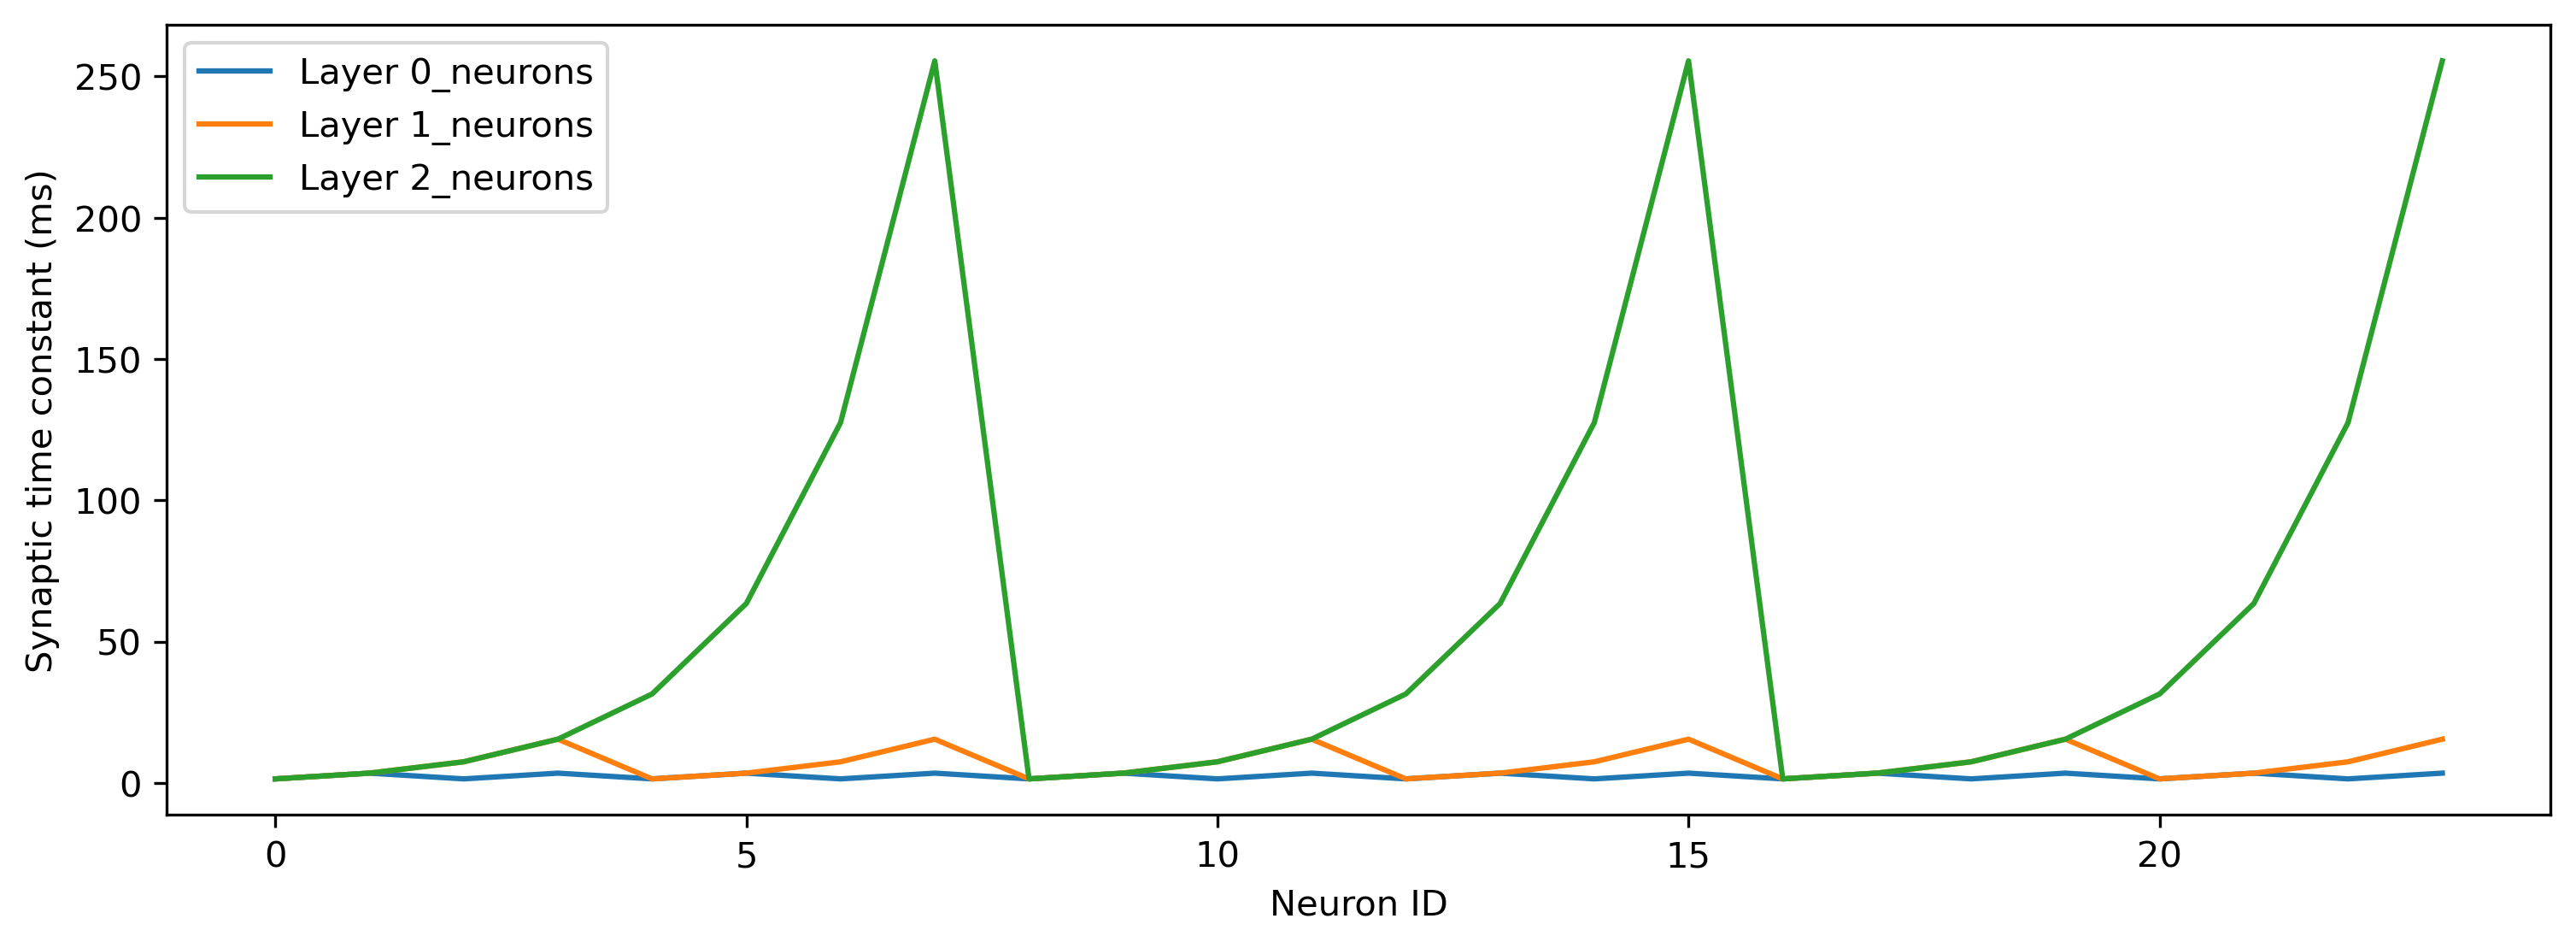

In [4]:
# - Import the matplotlib plotting library
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Plot the synaptic time constants for each layer
for lyr in net.lif_names[:-1]:
    plt.plot(net.seq[lyr].tau_syn / 1e-3, label = f"Layer {lyr}")

plt.xlabel('Neuron ID')
plt.ylabel('Synaptic time constant (ms)')
plt.legend();

## Accessing internal layers

In [5]:
# - Show the internal `Sequential` module
print(net.seq)

# - Print the list of neuron layer names
print(f"lif_names: {net.lif_names}")

TorchSequential 'seq' with shape (16, 1) {
    LinearTorch '0_linear' with shape (16, 24)
    LIFTorch '0_neurons' with shape (24, 24)
    LinearTorch '1_linear' with shape (24, 24)
    LIFTorch '1_neurons' with shape (24, 24)
    LinearTorch '2_linear' with shape (24, 24)
    LIFTorch '2_neurons' with shape (24, 24)
    LinearTorch 'out_linear' with shape (24, 1)
    LIFTorch 'out_neurons' with shape (1, 1)
}
lif_names: ['0_neurons', '1_neurons', '2_neurons', 'out_neurons']


In [6]:
lyr = net.seq[net.lif_names[0]]
print(lyr)

lyr_out = net.seq[-1]
print(lyr_out)

LIFTorch '0_neurons' with shape (24, 24)
LIFTorch 'out_neurons' with shape (1, 1)


In [7]:
for name, lyr in net.seq.modules().items():
    if 'linear' in name:
        print(lyr)

LinearTorch '0_linear' with shape (16, 24)
LinearTorch '1_linear' with shape (24, 24)
LinearTorch '2_linear' with shape (24, 24)
LinearTorch 'out_linear' with shape (24, 1)


## Modifying the architecture

In [ ]:
net = SynNet(
    output="v_mem",                         # Use the membrane potential as the output of the network

    n_channels = 16,                        # Number of input channels
    n_classes = 1,                          # Number of output classes (i.e. output channels)
    size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
)

net.output = "spike"

In [8]:
from rockpool.nn.modules import LIFTorch as LIFOtherSpiking

net = SynNet(
    neuron_model=LIFOtherSpiking,           # Specify a different neuron model to use

    n_channels = 16,                        # Number of input channels
    n_classes = 1,                          # Number of output classes (i.e. output channels)
    size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
)

In [9]:
net = SynNet(
    train_time_constants = True,            # Specify to train time constants
    train_threshold = True,                 # Specify to train thresholds

    n_channels = 16,                        # Number of input channels
    n_classes = 1,                          # Number of output classes (i.e. output channels)
    size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
)

net.seq['0_neurons'].parameters()

{'tau_mem': Parameter containing:
 tensor(0.0014, requires_grad=True),
 'tau_syn': Parameter containing:
 tensor([[0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035],
         [0.0014],
         [0.0035]], requires_grad=True),
 'threshold': Parameter containing:
 tensor(1., requires_grad=True)}

In [10]:
net = SynNet(
    p_dropout = 0.1,                        # Dropout proportion to use

    n_channels = 16,                        # Number of input channels
    n_classes = 1,                          # Number of output classes (i.e. output channels)
    size_hidden_layers = [24, 24, 24],      # Number of neurons in each hidden layer
    time_constants_per_layer = [2, 4, 8],   # Number of time constants in each hidden layer
)
print(net)

SynNet  with shape (16, 1) {
    TorchSequential 'seq' with shape (16, 1) {
        LinearTorch '0_linear' with shape (16, 24)
        LIFTorch '0_neurons' with shape (24, 24)
        TimeStepDropout '0_dropout' with shape (24,)
        LinearTorch '1_linear' with shape (24, 24)
        LIFTorch '1_neurons' with shape (24, 24)
        TimeStepDropout '1_dropout' with shape (24,)
        LinearTorch '2_linear' with shape (24, 24)
        LIFTorch '2_neurons' with shape (24, 24)
        TimeStepDropout '2_dropout' with shape (24,)
        LinearTorch 'out_linear' with shape (24, 1)
        LIFTorch 'out_neurons' with shape (1, 1)
    }
}


## Training a SynNet

This architecture can be trained with a standard ``torch`` training loop.
The below toy example simply shows the mechanics, without a real task.

In [23]:
n_epochs = 10
n_batch = 1
n_time = 100
n_channels = 4
n_classes = 1

# - Generate a SynNet
net = SynNet(
    n_channels=n_channels,
    n_classes=n_classes,
    size_hidden_layers=[4],
    )

# - Import torch training utilities
import torch
from torch.optim import Adam
from torch.nn import MSELoss

# - Try to use tqdm
try:
    from tqdm.notebook import trange
except:
    trange = range

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)

# - Loss function
loss_fun = MSELoss()

# - Record the loss values over training iterations
accuracy = []
loss_t = []

In [24]:
input_sp = (torch.rand(1, 100, 4) < 0.01) * 1.0
target_sp = torch.ones(1, 100, 1)

for epoch in trange(n_epochs):
    optimizer.zero_grad()

    output, _, _ = net(input_sp)

    loss = loss_fun(output, target_sp)

    loss.backward()
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

## Next steps